# Refactor tdnoisefit

Compute Hessian directly.

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np
import scipy.optimize as opt

from numpy.typing import ArrayLike
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz

## Simulate measurements
Simulate a set of `m` waveforms, each sampled at `n` time points, with noise parameters
`sigma_alpha`, `sigma_beta`, and `sigma_tau`, and store them in an array `x`. Note that
`x` stores the waveforms in row orientation, with shape `(m, n)`, because NumPy
broadcasting rules and FFT functions are simpler for arrays that are row-oriented.

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

## Compute Hessian numerically

In [5]:
logv = np.log(sigma**2)

def tdnll_mu(_mu):
    return thz.tdnll(x, _mu, logv, a, eta, ts, fix_logv=True, fix_mu=True, 
                 fix_a=True, fix_eta=True)[0]

hess = nd.Hessian(tdnll_mu, step=1e-10)(mu)

In [6]:
hess[:5, :5]

array([[ 6.41739355e+11,  0.00000000e+00, -7.27595641e+08,
        -7.27595641e+08,  0.00000000e+00],
       [ 0.00000000e+00,  6.45377334e+11, -6.54836077e+09,
         2.91038256e+09,  1.09139346e+10],
       [-7.27595641e+08, -6.54836077e+09,  6.35190995e+11,
         3.63797821e+09,  2.18278692e+09],
       [-7.27595641e+08,  2.91038256e+09,  3.63797821e+09,
         6.34463399e+11,  5.09316949e+09],
       [ 0.00000000e+00,  1.09139346e+10,  2.18278692e+09,
         5.09316949e+09,  6.43922142e+11]])

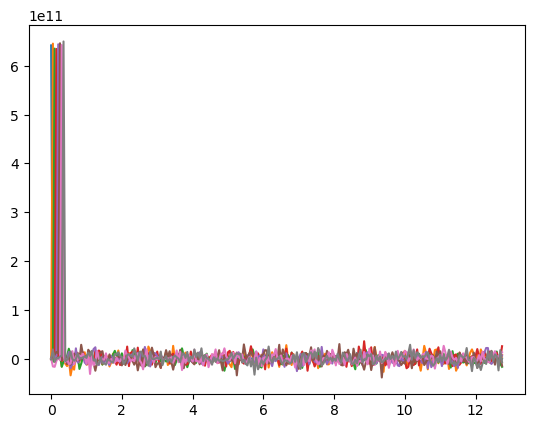

In [8]:
for i in range(8):
    plt.plot(t, hess[:, i])
plt.show()

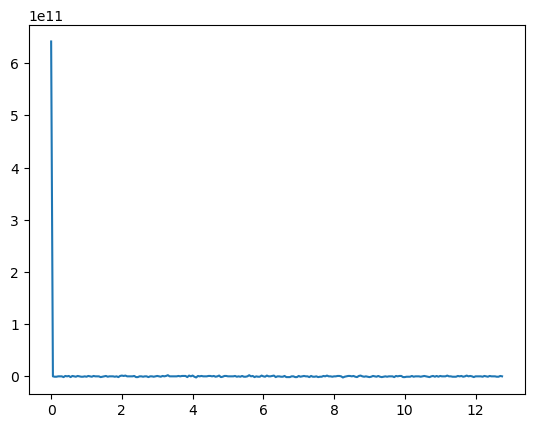

In [9]:
plt.plot(t, hess[:, 0])
plt.show()

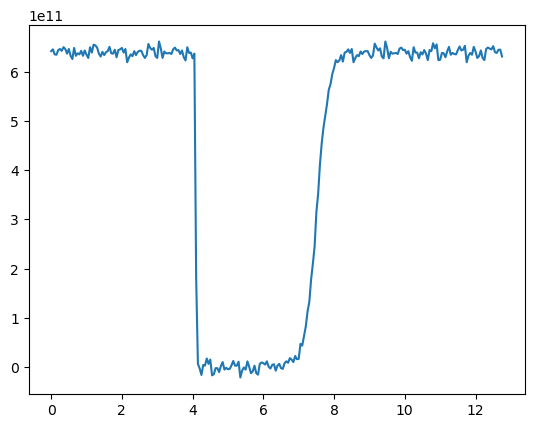

In [11]:
plt.plot(t, np.diag(hess))
plt.show()